--- 步骤 1: 加载并归一化主地图 ---
主地图已加载并归一化为 621x631。

--- 步骤 2: 开始进行多模板匹配 ---
--- 步骤 2a: 查找玩家位置 ---
找到了 3 个玩家模板: ['player.png', 'player1.png', 'player2.png']
-> 玩家位置已确认！

--- 步骤 2b: 查找所有据点位置 ---

--- 正在匹配 'castle' 类别下的 1 个模板...
-> 对 'castle' 类别去重后，最终确认 0 个物体。

--- 正在匹配 'church' 类别下的 4 个模板...
  - 模板 'church.png' 找到了 2 个匹配项。
  - 模板 'church1.png' 找到了 2 个匹配项。
  - 模板 'church2.png' 找到了 2 个匹配项。
  - 模板 'church3.png' 找到了 2 个匹配项。
-> 对 'church' 类别去重后，最终确认 3 个物体。

--- 正在匹配 'churchBig' 类别下的 2 个模板...
  - 模板 'churchBig1.png' 找到了 1 个匹配项。
-> 对 'churchBig' 类别去重后，最终确认 1 个物体。

--- 正在匹配 'evergaol' 类别下的 3 个模板...
  - 模板 'evergaol.png' 找到了 1 个匹配项。
-> 对 'evergaol' 类别去重后，最终确认 1 个物体。

--- 正在匹配 'fort' 类别下的 3 个模板...
-> 对 'fort' 类别去重后，最终确认 0 个物体。

--- 正在匹配 'mainEncampment' 类别下的 4 个模板...
  - 模板 'mainEncampment2.png' 找到了 1 个匹配项。
-> 对 'mainEncampment' 类别去重后，最终确认 1 个物体。

--- 正在匹配 'ruins' 类别下的 3 个模板...
  - 模板 'ruins.png' 找到了 2 个匹配项。
-> 对 'ruins' 类别去重后，最终确认 2 个物体。

--- 正在匹配 'tunnelEntrance' 类别下的 3 个模板...
  - 模板 'tunnelEntrance.p

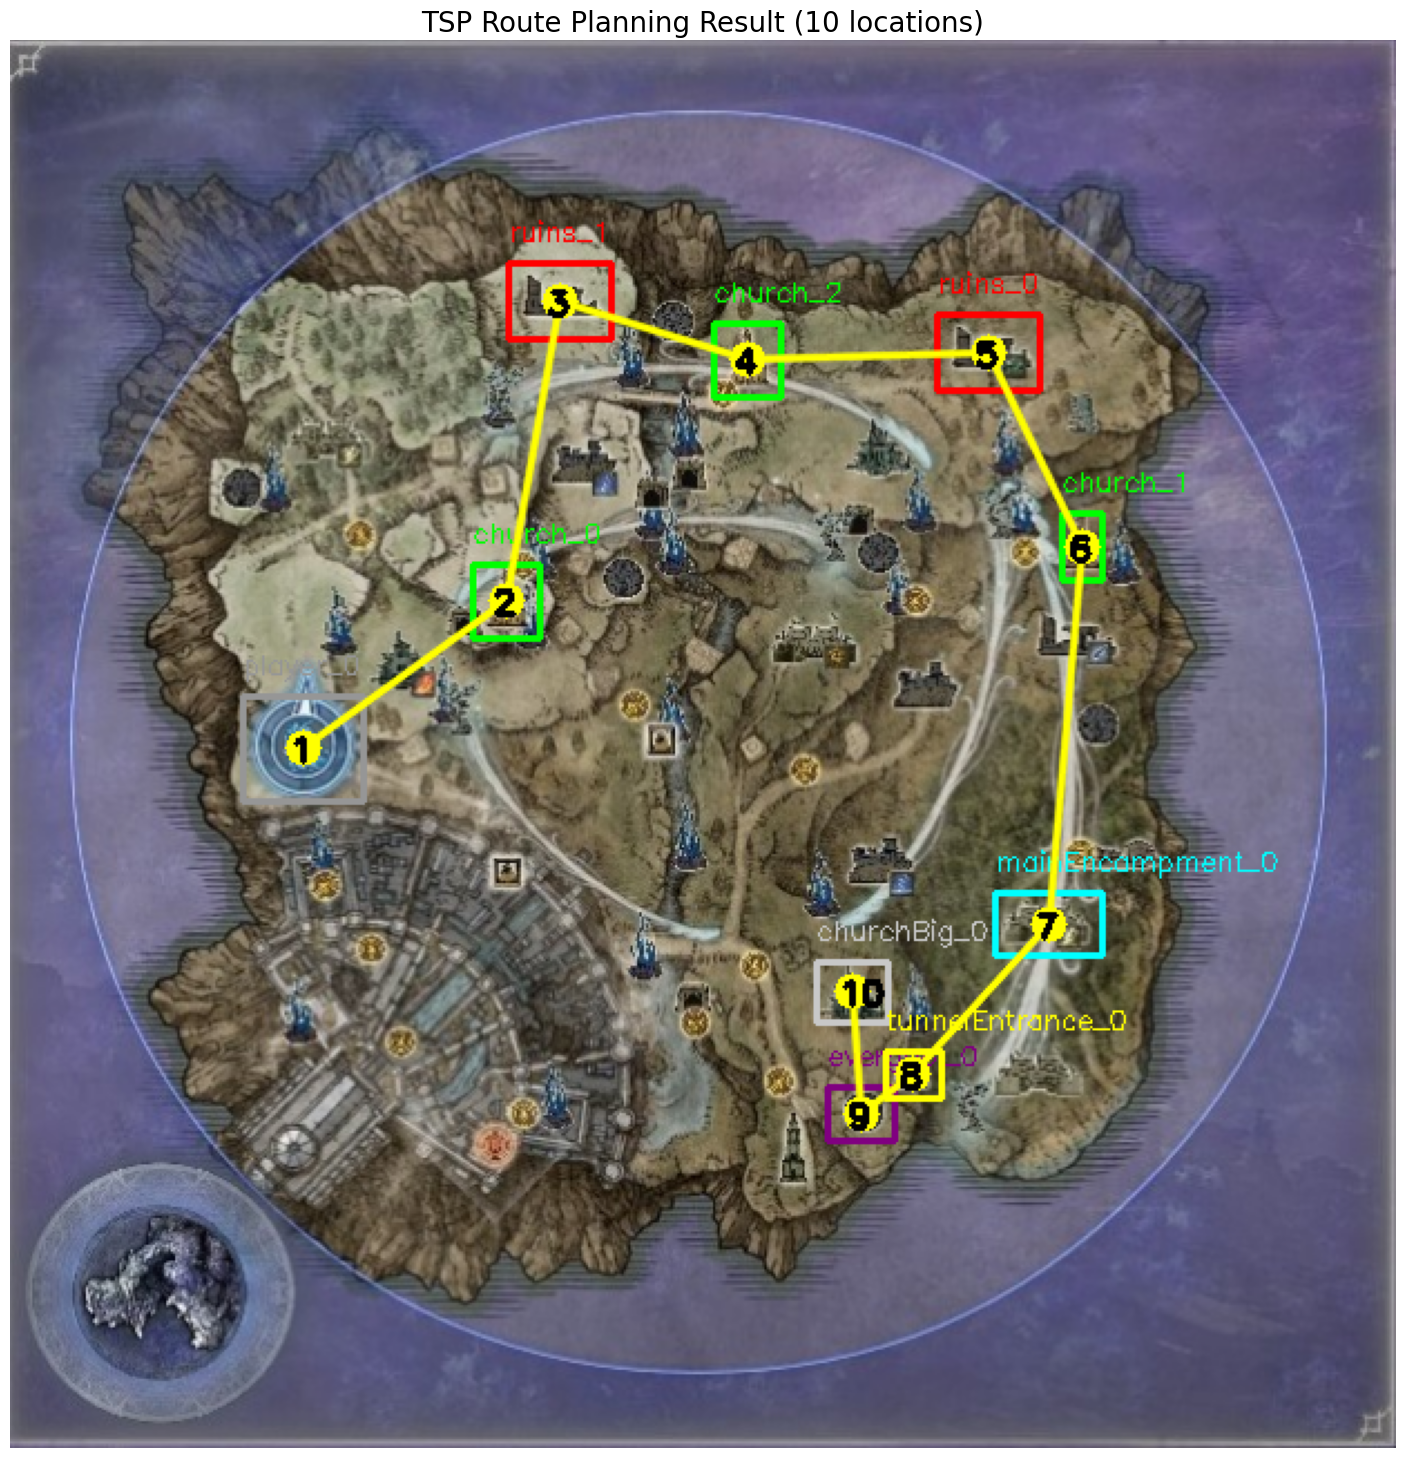


结果已保存到文件: D:\EldenNightDev\Test\tsp_route_result.png


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re # 引入正则表达式库，用于解析模板文件名

# 在Jupyter Notebook或IPython中，这行可以让matplotlib的图像直接显示
%matplotlib inline 

# ===================================================================
#                      1. 参数和全局设置
# ===================================================================

# --- 核心路径设置 ---
# 【修改这里】指向你的地图文件
MAP_IMAGE_PATH = r"D:\EldenNightDev\Test\map3.png" 
# 【修改这里】指向你存放所有模板的文件夹
TEMPLATE_FOLDER = r"D:\EldenNightDev\testTemplates"
OUTPUT_DIRECTORY = r"D:\EldenNightDev\Test"
# 定义归一化后的目标尺寸 (宽度, 高度)
TARGET_MAP_SIZE = (621, 631)

# --- 匹配和去重阈值 ---
MATCH_THRESHOLD = 0.938    # 模板匹配的相似度阈值，越高越严格
NMS_OVERLAP_THRESHOLD = 0.3 # 非极大值抑制的重叠阈值，越小去重越狠

# --- 节点权重（收益）设置 ---
# 权重字典，用于为不同类型的地点分配“收益”值
WEIGHTS_MAP = {
    'player':100,
    'church': 6,
    'fort': 7,
    'ruins': 3,  
    'castel': 8, 
    'evergaol': 5,
    'mainEncampment': 4,
    'tunnelEntrance': 4,
    'default': 1 
}

# --- 可视化颜色设置 ---
COLOR_MAP = {
    'player':(150,150,150),
    'church': (0, 255, 0),       # 绿色
    'fort': (255, 0, 0),         # 蓝色
    'ruins': (0, 0, 255),         # 红色
    'castel': (0, 165, 255),     # 橙色
    'evergaol': (128, 0, 128),   # 紫色
    'mainEncampment': (255, 255, 0), # 黄色
    'tunnelEntrance': (0, 255, 255), # 青色
    'default': (200, 200, 200)   # 默认灰色
}


# ===================================================================
#                      2. 核心功能函数
# ===================================================================

def non_max_suppression(boxes, overlap_thresh):
    if len(boxes) == 0: return []
    if boxes.dtype.kind == "i": boxes = boxes.astype("float")
    pick = []
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1, yy1 = np.maximum(x1[i], x1[idxs[:last]]), np.maximum(y1[i], y1[idxs[:last]])
        xx2, yy2 = np.minimum(x2[i], x2[idxs[:last]]), np.minimum(y2[i], y2[idxs[:last]])
        w, h = np.maximum(0, xx2 - xx1 + 1), np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    return boxes[pick].astype("int")

def calculate_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def solve_tsp_nearest_neighbor(distance_matrix, nodes, start_node_index=0):
    """
    使用最近邻贪心算法解决TSP问题。
    可以指定一个起始节点的索引。
    """
    num_nodes = len(nodes)
    if num_nodes <= 1:
        return nodes, 0
        
    unvisited = list(range(num_nodes))
    path_indices = []
    total_distance = 0

    # 设置起始节点
    current_node_idx = start_node_index
    # 确保起始点在可访问列表里
    if current_node_idx not in unvisited:
        print(f"警告：指定的起始索引 {current_node_idx} 无效，将从默认的第一个节点开始。")
        current_node_idx = unvisited[0]

    path_indices.append(current_node_idx)
    unvisited.remove(current_node_idx)

    while unvisited:
        nearest_node_idx = -1
        min_distance = float('inf')
        for neighbor_idx in unvisited:
            dist = distance_matrix[current_node_idx, neighbor_idx]
            if dist < min_distance:
                min_distance = dist
                nearest_node_idx = neighbor_idx
        
        if nearest_node_idx == -1: break

        total_distance += min_distance
        current_node_idx = nearest_node_idx
        path_indices.append(current_node_idx)
        unvisited.remove(current_node_idx)
        
    ordered_nodes = [nodes[i] for i in path_indices]
    return ordered_nodes, total_distance

def get_base_type_from_filename(filename):
    """从文件名中提取基础类型，例如 'churchBig1' -> 'church'"""
    # 使用正则表达式，匹配开头的字母部分
    match = re.match(r"([a-zA-Z]+)", filename)
    return match.group(1) if match else "unknown"

def find_objects_with_template(map_gray_img, template_path):
    """使用单个模板在地图上查找所有匹配的对象。"""
    template_with_alpha = cv2.imread(template_path, cv2.IMREAD_UNCHANGED)
    if template_with_alpha is None: return []

    if template_with_alpha.shape[2] == 4:
        template_bgr = template_with_alpha[:, :, :3]
        mask = template_with_alpha[:, :, 3]
        _, mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    else:
        template_bgr = template_with_alpha
        mask = None
    
    template_gray = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2GRAY)
    t_w, t_h = template_gray.shape[::-1]

    result = cv2.matchTemplate(map_gray_img, template_gray, cv2.TM_CCORR_NORMED, mask=mask)
    locations = np.where(result >= MATCH_THRESHOLD)
    
    rectangles = []
    for (y, x) in zip(*locations):
        rectangles.append((x, y, x + t_w, y + t_h))
        
    return non_max_suppression(np.array(rectangles), NMS_OVERLAP_THRESHOLD), t_w, t_h

# ===================================================================
#                       3. 主执行流程封装
# ===================================================================

def main():
    """主执行函数"""
    # --- 步骤 1: 加载和预处理主地图 ---
    print("--- 步骤 1: 加载并归一化主地图 ---")
    map_image_bgr = cv2.imread(MAP_IMAGE_PATH)
    if map_image_bgr is None:
        raise FileNotFoundError(f"地图文件未找到: {MAP_IMAGE_PATH}")
    
    # 归一化地图
    map_bgr_resized = cv2.resize(map_image_bgr, TARGET_MAP_SIZE, interpolation=cv2.INTER_AREA)
    map_gray = cv2.cvtColor(map_bgr_resized, cv2.COLOR_BGR2GRAY)
    print(f"主地图已加载并归一化为 {TARGET_MAP_SIZE[0]}x{TARGET_MAP_SIZE[1]}。\n")
    
        # --- 步骤 2: 多模板匹配 ---
    print("--- 步骤 2: 开始进行多模板匹配 ---")
    all_found_objects = []
    
    # 从模板文件夹读取所有png文件名
    all_template_files = sorted([f for f in os.listdir(TEMPLATE_FOLDER) if f.endswith('.png')])
    
    # 将玩家模板和其他模板分离开
    player_template_files = [f for f in all_template_files if get_base_type_from_filename(f) == 'player']
    other_template_files = [f for f in all_template_files if get_base_type_from_filename(f) != 'player']

    # --- 步骤 2a: 查找玩家位置 ---
    print("--- 步骤 2a: 查找玩家位置 ---")
    player_node = None
    if player_template_files:
        print(f"找到了 {len(player_template_files)} 个玩家模板: {player_template_files}")
        all_player_rectangles = []
        for filename in player_template_files:
            player_template_path = os.path.join(TEMPLATE_FOLDER, filename)
            boxes, _, _ = find_objects_with_template(map_gray, player_template_path)
            if len(boxes) > 0:
                all_player_rectangles.extend(boxes)
        
        final_player_boxes = non_max_suppression(np.array(all_player_rectangles), NMS_OVERLAP_THRESHOLD)
        if len(final_player_boxes) > 0:
            box = final_player_boxes[0]
            startX, startY, endX, endY = box
            player_node = {
                "id": "player_0", "type": "player", "box": tuple(box),
                "center": (startX + (endX - startX) // 2, startY + (endY - startY) // 2),
                "weight": WEIGHTS_MAP.get('player', 100)
            }
            all_found_objects.append(player_node)
            print(f"-> 玩家位置已确认！\n")
        else:
            print("警告：未在地图上找到玩家图标。\n")
    else:
        print("警告：在模板文件夹中未找到玩家模板文件。\n")

    # --- 步骤 2b: 查找所有据点位置 ---
    print("--- 步骤 2b: 查找所有据点位置 ---")
    # 【修改】直接使用已经分离好的 other_template_files 来进行分组
    templates_by_type = {}
    for filename in other_template_files:
        base_type = get_base_type_from_filename(filename)
        if base_type not in templates_by_type:
            templates_by_type[base_type] = []
        templates_by_type[base_type].append(filename)

    # 【修改】现在这个循环只会处理据点，不会再处理玩家
    for base_type, filenames in templates_by_type.items():
        print(f"\n--- 正在匹配 '{base_type}' 类别下的 {len(filenames)} 个模板...")
        type_rectangles = []
        for filename in filenames:
            template_path = os.path.join(TEMPLATE_FOLDER, filename)
            boxes, _, _ = find_objects_with_template(map_gray, template_path)
            if len(boxes) > 0:
                print(f"  - 模板 '{filename}' 找到了 {len(boxes)} 个匹配项。")
                type_rectangles.extend(boxes)
        
        final_boxes_for_type = non_max_suppression(np.array(type_rectangles), NMS_OVERLAP_THRESHOLD)
        print(f"-> 对 '{base_type}' 类别去重后，最终确认 {len(final_boxes_for_type)} 个物体。")

        # 整理找到的对象
        for i, box in enumerate(final_boxes_for_type):
            startX, startY, endX, endY = box
            all_found_objects.append({
                "id": f"{base_type}_{i}", "type": base_type, "box": tuple(box),
                "center": (startX + (endX - startX) // 2, startY + (endY - startY) // 2),
                "weight": WEIGHTS_MAP.get(base_type, WEIGHTS_MAP['default'])
            })

    print(f"\n--- 所有模板匹配完成！总共找到了 {len(all_found_objects)} 个物体。---\n")
    # --- 步骤 3: 构建距离矩阵 ---
    print("--- 步骤 3: 构建节点间的距离矩阵 ---")
    num_objects = len(all_found_objects)
    distance_matrix = np.zeros((num_objects, num_objects))
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            dist = calculate_distance(all_found_objects[i]['center'], all_found_objects[j]['center'])
            distance_matrix[i, j] = distance_matrix[j, i] = dist
    print("距离矩阵构建完成。\n")

    # --- 步骤 4: 运行TSP算法求解路径 ---
    print("--- 步骤 4: 使用最近邻算法计算最优路径 ---")
    start_index = 0 # 默认从第0个节点开始
    if player_node:
        # 如果找到了玩家，我们就找到它在列表中的索引，并从那里开始
        try:
            start_index = all_found_objects.index(player_node)
            print(f"检测到玩家节点，将从玩家位置（索引 {start_index}）开始规划路线。")
        except ValueError:
            print("错误：玩家节点在列表中未找到，将从默认位置开始。")
            
    optimal_path_nodes, total_travel_distance = solve_tsp_nearest_neighbor(distance_matrix, all_found_objects, start_node_index=start_index)
    print(f"路径计算完成！总行程距离: {total_travel_distance:.2f} 像素距离。")
    print("推荐访问顺序如下:")
    total_weight = 0
    for i, node in enumerate(optimal_path_nodes):
        print(f"  {i+1}. {node['id']} (类型: {node['type']}, 权重: {node['weight']})")
        total_weight += node['weight']
    print(f"\n路线总收益（权重和）: {total_weight}")


    # --- 步骤 5: 可视化结果 ---
    print("\n--- 步骤 5: 生成结果可视化图像 ---")
    route_image = map_bgr_resized.copy()
    
    # 绘制所有检测框
    for node in all_found_objects:
        (startX, startY, endX, endY) = node['box']
        color = COLOR_MAP.get(node['type'], COLOR_MAP['default'])
        cv2.rectangle(route_image, (startX, startY), (endX, endY), color, 2)
        cv2.putText(route_image, f"{node['id']}", (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # 绘制TSP路线
    if len(optimal_path_nodes) > 1:
        for i in range(len(optimal_path_nodes) - 1):
            p1 = optimal_path_nodes[i]['center']
            p2 = optimal_path_nodes[i+1]['center']
            cv2.line(route_image, p1, p2, (0, 255, 255), 2, cv2.LINE_AA)
            cv2.circle(route_image, p1, 8, (0, 255, 255), -1)
            cv2.putText(route_image, str(i + 1), (p1[0] - 6, p1[1] + 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        
        last_node_center = optimal_path_nodes[-1]['center']
        cv2.circle(route_image, last_node_center, 8, (0, 255, 255), -1)
        cv2.putText(route_image, str(len(optimal_path_nodes)), (last_node_center[0] - 6, last_node_center[1] + 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        
    # 显示最终图像
    plt.figure(figsize=(18, 18 * (TARGET_MAP_SIZE[1]/TARGET_MAP_SIZE[0]))) # 保持长宽比
    plt.title(f'TSP Route Planning Result ({len(all_found_objects)} locations)', fontsize=20)
    plt.imshow(cv2.cvtColor(route_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # 保存结果文件
     # 定义输出文件名
    output_filename = 'tsp_route_result.png'

    # 使用 os.path.join 来安全地构建完整的文件路径
    full_output_path = os.path.join(OUTPUT_DIRECTORY, output_filename)

    # 检查并确保输出目录存在，如果不存在就创建它
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

    # 使用完整的路径来保存文件
    cv2.imwrite(full_output_path, route_image)

    # 在提示信息中也显示完整路径
    print(f"\n结果已保存到文件: {full_output_path}")


# ===================================================================
#                       4. 运行主程序
# ===================================================================
if __name__ == '__main__':
    main()

          V2.0 - 点插入算法路线规划器

--- 步骤 1: 加载并归一化主地图 ---
主地图已加载并归一化为 621x631。

--- 步骤 2: 识别所有节点 ---
识别完成！总共找到了 10 个物体。

--- 步骤 3: 使用点插入算法规划收益路线 ---
最大旅行距离限制为: 3000
检测到玩家节点，将从玩家位置（列表索引 0）开始规划路线。

开始迭代插入节点...
  迭代 1: 插入节点 'church_0'。 增加距离: 112.41, 增加收益: 6. 当前总距离: 112.41/3000
  迭代 2: 插入节点 'church_2'。 增加距离: 152.74, 增加收益: 6. 当前总距离: 265.15/3000
  迭代 3: 插入节点 'ruins_1'。 增加距离: 71.33, 增加收益: 3. 当前总距离: 336.48/3000
  迭代 4: 插入节点 'church_1'。 增加距离: 171.92, 增加收益: 6. 当前总距离: 508.40/3000
  迭代 5: 插入节点 'ruins_0'。 增加距离: 32.73, 增加收益: 3. 当前总距离: 541.13/3000
  迭代 6: 插入节点 'mainEncampment_0'。 增加距离: 169.66, 增加收益: 4. 当前总距离: 710.79/3000
  迭代 7: 插入节点 'tunnelEntrance_0'。 增加距离: 90.61, 增加收益: 4. 当前总距离: 801.40/3000
  迭代 8: 插入节点 'evergaol_0'。 增加距离: 29.21, 增加收益: 5. 当前总距离: 830.61/3000
  迭代 9: 插入节点 'churchBig_0'。 增加距离: 48.17, 增加收益: 1. 当前总距离: 878.78/3000

--- 路线规划完成! ---
总行程距离: 878.78 (限制: 3000)
路线总收益: 138
推荐访问顺序如下:
  起点: player_0 (类型: player, 权重: 100)
  1. church_0 (类型: church, 权重: 6)
  2. ruins_1 (类型: ruins, 权重: 3)
  3. church_2 

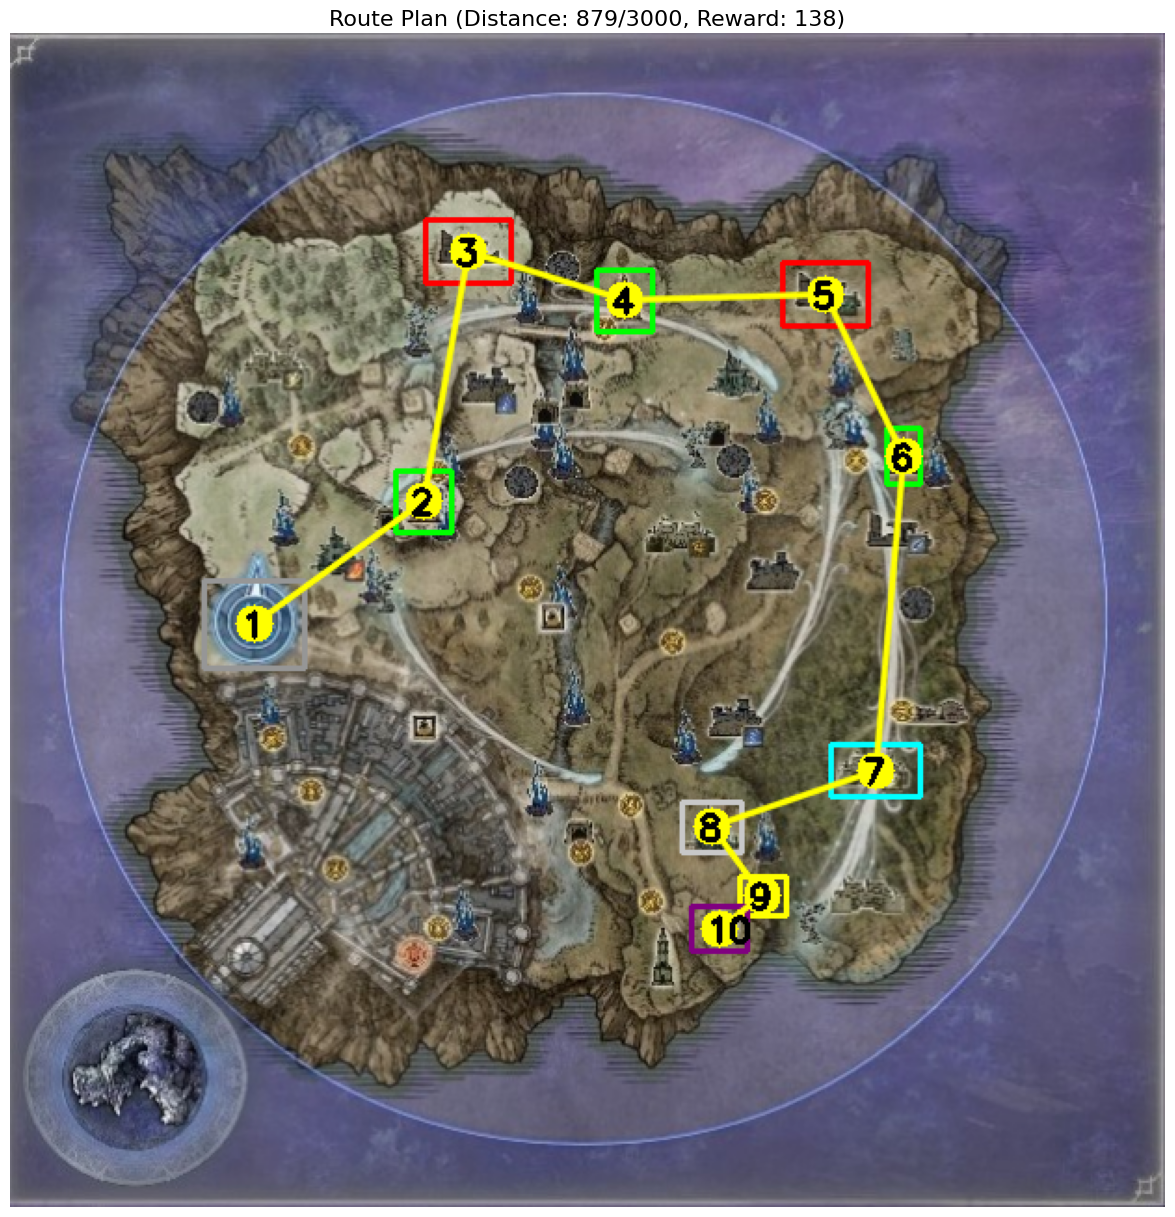

结果已保存到文件: D:\EldenNightDev\Test\op_route_result_dist3000.png


In [19]:
# ===================================================================
#      V2.0 - 点插入启发式算法 (寻宝问题)
# ===================================================================
# 这个单元格包含了运行新算法所需的所有代码。
# 你可以独立运行这个单元格，前提是之前的单元格已经定义了
# 必要的全局变量（如路径、阈值）和基础函数（如 find_objects_with_template）。

# --- 1. V2.0 算法的新增参数 ---
MAX_TRAVEL_DISTANCE = 3000  # 【可调参数】设置一个最大旅行距离限制 (单位：像素)

# --- 2. V2.0 核心算法函数 ---
def solve_op_insertion_heuristic(nodes, max_distance, start_node_index=0):
    """
    使用点插入启发式算法解决寻宝问题 (Orienteering Problem)。
    目标：在不超过最大距离的前提下，最大化总收益。
    【V2.1 修正了起点处理和插入逻辑】
    """
    if not nodes:
        return [], 0, 0

    # 确保起始索引有效
    if not (0 <= start_node_index < len(nodes)):
        print(f"警告：指定的起始索引 {start_node_index} 无效，将从默认的第一个节点开始。")
        start_node_index = 0
        
    # --- 1. 初始化路线 ---
    # 路线从指定的起点开始
    start_node = nodes[start_node_index]
    path_nodes = [start_node]
    path_indices = [start_node_index]
    
    current_distance = 0.0
    # 起点的权重不计入“收益”
    current_reward = 0 
    
    # 从未访问列表中移除起点
    unvisited_indices = set(range(len(nodes)))
    unvisited_indices.remove(start_node_index)

    print("\n开始迭代插入节点...")
    iteration_count = 1
    while True:
        best_candidate_index = -1
        best_insertion_info = None
        max_score = -1e9

        if not unvisited_indices:
            break

        # --- 2. 遍历所有未访问节点，寻找最佳插入选择 ---
        for node_idx in unvisited_indices:
            candidate_node = nodes[node_idx]
            
            # --- 为该候选节点寻找最佳插入位置 ---
            best_insertion_cost = float('inf')
            best_insertion_pos = -1

            # 遍历当前路线的所有“间隙”来寻找最佳插入点
            # 路线 [A, B, C] 有间隙 (-inf, A), (A,B), (B,C), (C, +inf)
            # 但我们只考虑在已有路径中插入
            if len(path_nodes) == 1: # 只有一个起点
                # 只能加在起点后面，形成 A -> K 的路径
                cost = calculate_distance(path_nodes[0]['center'], candidate_node['center'])
                if cost < best_insertion_cost:
                    best_insertion_cost = cost
                    best_insertion_pos = 1 # 插入到索引为1的位置
            else:
                # 遍历所有可以插入的位置，包括开头和结尾
                for i in range(len(path_nodes) + 1):
                    if i == 0: # 插入在最前面
                        cost = calculate_distance(candidate_node['center'], path_nodes[0]['center'])
                    elif i == len(path_nodes): # 插入在最后面
                        cost = calculate_distance(path_nodes[-1]['center'], candidate_node['center'])
                    else: # 插入在中间 (i-1 和 i 之间)
                        prev_node = path_nodes[i-1]
                        next_node = path_nodes[i]
                        cost = (calculate_distance(prev_node['center'], candidate_node['center']) +
                                calculate_distance(candidate_node['center'], next_node['center']) -
                                calculate_distance(prev_node['center'], next_node['center']))
                    
                    if cost < best_insertion_cost:
                        best_insertion_cost = cost
                        best_insertion_pos = i

            # --- 计算该候选节点的性价比 ---
            score = candidate_node['weight'] / best_insertion_cost if best_insertion_cost > 1e-9 else float('inf')
            
            if score > max_score:
                if current_distance + best_insertion_cost <= max_distance:
                    max_score = score
                    best_candidate_index = node_idx
                    best_insertion_info = (best_insertion_pos, best_insertion_cost)

        # --- 3. 如果找不到可插入的节点，则结束 ---
        if best_candidate_index == -1:
            print("没有更多可插入的节点（已达到距离限制或无剩余高性价比节点）。")
            break

        # --- 4. 执行最佳插入 ---
        (pos, cost) = best_insertion_info
        
        path_nodes.insert(pos, nodes[best_candidate_index])
        path_indices.insert(pos, best_candidate_index)
        
        current_distance += cost
        current_reward += nodes[best_candidate_index]['weight']
        unvisited_indices.remove(best_candidate_index)

        print(f"  迭代 {iteration_count}: 插入节点 '{nodes[best_candidate_index]['id']}'。 "
              f"增加距离: {cost:.2f}, 增加收益: {nodes[best_candidate_index]['weight']}. "
              f"当前总距离: {current_distance:.2f}/{max_distance}")
        iteration_count += 1
            
    # 最终路线的总收益需要加上起点的权重
    final_total_reward = current_reward + path_nodes[0]['weight']
    
    return path_nodes, current_distance, final_total_reward

# --- 3. V2.0 主执行函数 ---
def run_advanced_planner():
    """
    一个完整独立的函数，用于执行V2.0的识别和规划流程。
    它会调用之前单元格定义的全局变量和基础函数。
    """
    print("======================================================")
    print("          V2.0 - 点插入算法路线规划器")
    print("======================================================")
    
    # --- 步骤 1: 加载和预处理主地图 ---
    print("\n--- 步骤 1: 加载并归一化主地图 ---")
    map_image_bgr = cv2.imread(MAP_IMAGE_PATH)
    if map_image_bgr is None:
        raise FileNotFoundError(f"地图文件未找到: {MAP_IMAGE_PATH}")
    map_bgr_resized = cv2.resize(map_image_bgr, TARGET_MAP_SIZE, interpolation=cv2.INTER_AREA)
    map_gray = cv2.cvtColor(map_bgr_resized, cv2.COLOR_BGR2GRAY)
    print(f"主地图已加载并归一化为 {TARGET_MAP_SIZE[0]}x{TARGET_MAP_SIZE[1]}。")

    # --- 步骤 2: 识别所有节点  ---
    print("\n--- 步骤 2: 识别所有节点 ---")
    all_found_objects = []
    all_template_files = sorted([f for f in os.listdir(TEMPLATE_FOLDER) if f.endswith('.png')])
    player_template_files = [f for f in all_template_files if get_base_type_from_filename(f) == 'player']
    other_template_files = [f for f in all_template_files if get_base_type_from_filename(f) != 'player']
    # 查找玩家
    if player_template_files:
        all_player_rectangles = []
        for filename in player_template_files:
            boxes, _, _ = find_objects_with_template(map_gray, os.path.join(TEMPLATE_FOLDER, filename))
            if len(boxes) > 0: all_player_rectangles.extend(boxes)
        final_player_boxes = non_max_suppression(np.array(all_player_rectangles), NMS_OVERLAP_THRESHOLD)
        if len(final_player_boxes) > 0:
            box = final_player_boxes[0]
            all_found_objects.append({"id": "player_0", "type": "player", "box": tuple(box), "center": (box[0] + (box[2] - box[0]) // 2, box[1] + (box[3] - box[1]) // 2), "weight": WEIGHTS_MAP.get('player', 100)})
    # 查找据点
    templates_by_type = {}
    for filename in other_template_files:
        base_type = get_base_type_from_filename(filename)
        if base_type not in templates_by_type: templates_by_type[base_type] = []
        templates_by_type[base_type].append(filename)
    for base_type, filenames in templates_by_type.items():
        type_rectangles = []
        for filename in filenames:
            boxes, _, _ = find_objects_with_template(map_gray, os.path.join(TEMPLATE_FOLDER, filename))
            if len(boxes) > 0: type_rectangles.extend(boxes)
        final_boxes_for_type = non_max_suppression(np.array(type_rectangles), NMS_OVERLAP_THRESHOLD)
        for i, box in enumerate(final_boxes_for_type):
            all_found_objects.append({"id": f"{base_type}_{i}", "type": base_type, "box": tuple(box), "center": (box[0] + (box[2] - box[0]) // 2, box[1] + (box[3] - box[1]) // 2), "weight": WEIGHTS_MAP.get(base_type, 1)})
    print(f"识别完成！总共找到了 {len(all_found_objects)} 个物体。")


    # --- 步骤 3: 运行新的寻宝算法 ---
    print("\n--- 步骤 3: 使用点插入算法规划收益路线 ---")
    print(f"最大旅行距离限制为: {MAX_TRAVEL_DISTANCE}")
    
    start_index = 0
    try:
        start_index = [i for i, node in enumerate(all_found_objects) if node['type'] == 'player'][0]
        print(f"检测到玩家节点，将从玩家位置（列表索引 {start_index}）开始规划路线。")
    except IndexError:
        print("警告：未找到玩家节点，将从列表中的第一个物体开始规划。")
    
    # 调用【修正后】的算法
    optimal_path_nodes, total_distance, total_reward = solve_op_insertion_heuristic(
        all_found_objects, 
        max_distance=MAX_TRAVEL_DISTANCE, 
        start_node_index=start_index
    )
    # --- 步骤 4: 打印和可视化结果 ---
    print("\n--- 路线规划完成! ---")
    print(f"总行程距离: {total_distance:.2f} (限制: {MAX_TRAVEL_DISTANCE})")
    print(f"路线总收益: {total_reward}")
    print("推荐访问顺序如下:")
    if optimal_path_nodes:
        start_node = optimal_path_nodes[0]
        print(f"  起点: {start_node['id']} (类型: {start_node['type']}, 权重: {start_node['weight']})")
        for i, node in enumerate(optimal_path_nodes[1:], 1): # 从第二个节点开始编号为1
            print(f"  {i}. {node['id']} (类型: {node['type']}, 权重: {node['weight']})")

    route_image = map_bgr_resized.copy()
    if optimal_path_nodes:
        # 绘制所有在路线中的节点框
        for node in optimal_path_nodes:
            (startX, startY, endX, endY) = node['box']
            color = COLOR_MAP.get(node['type'], COLOR_MAP['default'])
            cv2.rectangle(route_image, (startX, startY), (endX, endY), color, 2)
        # 绘制路线
        for i in range(len(optimal_path_nodes) - 1):
            p1 = optimal_path_nodes[i]['center']; p2 = optimal_path_nodes[i+1]['center']
            cv2.line(route_image, p1, p2, (0, 255, 255), 2, cv2.LINE_AA)
        # 绘制序号
        for i, node in enumerate(optimal_path_nodes):
            p = node['center']
            cv2.circle(route_image, p, 10, (0, 255, 255), -1)
            cv2.putText(route_image, str(i + 1), (p[0] - 7, p[1] + 7), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            
    plt.figure(figsize=(15, 15 * (TARGET_MAP_SIZE[1]/TARGET_MAP_SIZE[0])))
    plt.title(f'Route Plan (Distance: {total_distance:.0f}/{MAX_TRAVEL_DISTANCE}, Reward: {total_reward})', fontsize=16)
    plt.imshow(cv2.cvtColor(route_image, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.show()

    # --- 步骤 5: 保存结果 ---
    output_filename = f'op_route_result_dist{MAX_TRAVEL_DISTANCE}.png'
    full_output_path = os.path.join(OUTPUT_DIRECTORY, output_filename)
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
    cv2.imwrite(full_output_path, route_image)
    print(f"结果已保存到文件: {full_output_path}")


# --- 4. 运行主程序 ---
run_advanced_planner()